# Simple Trading Rule

In [1]:
from sysdata.sim.csv_futures_sim_data import csvFuturesSimData
import matplotlib.pyplot as plt
%matplotlib inline

Configuring sim logging


Work up a minimum example of a trend following system

Let's get some data

In [27]:
from syscore.pandas.pdutils import pd_readcsv
inpath = '../data/in/'
instrument_code = 'BTC-USDT'
data = pd_readcsv(inpath +"/coinbase/" + instrument_code + '_raw.csv', date_index_name='Date')
price = data['Close']

data can also behave in a dict like manner (though it's not a dict)

In [28]:
data

,Low,High,Open,Close,Volume
2022-11-21,15477.17,16316.92,16274.31,15778.08,2697.203839
2022-11-22,15616.67,16311.45,15790.32,16213.71,1422.313420
2022-11-23,16164.99,16709.81,16222.62,16608.27,1663.200300
2022-11-24,16463.67,16815.04,16606.24,16599.54,1647.281304
2022-11-25,16347.86,16622.70,16601.34,16519.97,2266.939379
...,...,...,...,...,...
2023-09-12,25134.79,26556.20,25163.52,25839.64,2947.572642
2023-09-13,25764.55,26407.42,25841.68,26221.00,1782.612013
2023-09-14,26124.23,26861.88,26225.60,26527.51,1719.006092
2023-09-15,26222.00,26894.71,26520.90,26610.13,886.874393


Let's create a simple trading rule

No capping or scaling

In [4]:
import pandas as pd
from sysquant.estimators.vol import robust_vol_calc


def calc_ewmac_forecast(price, Lfast, Lslow=None):
    """
    Calculate the ewmac trading rule forecast, given a price and EWMA speeds
    Lfast, Lslow and vol_lookback

    """
    # price: This is the stitched price series
    # We can't use the price of the contract we're trading, or the volatility
    # will be jumpy
    # And we'll miss out on the rolldown. See
    # https://qoppac.blogspot.com/2015/05/systems-building-futures-rolling.html

    price = price.resample("1B").last()

    if Lslow is None:
        Lslow = 4 * Lfast

    # We don't need to calculate the decay parameter, just use the span
    # directly
    fast_ewma = price.ewm(span=Lfast).mean()
    slow_ewma = price.ewm(span=Lslow).mean()
    raw_ewmac = fast_ewma - slow_ewma
    vol = robust_vol_calc(price.diff())
    return raw_ewmac / vol


Try it out

(this isn't properly scaled at this stage of course)


In [29]:
ewmac = calc_ewmac_forecast(price, 32, 128)
ewmac.columns = ['forecast']
ewmac.tail(5)

2023-09-11   -0.311013
2023-09-12   -0.394924
2023-09-13   -0.455911
2023-09-14   -0.494176
2023-09-15   -0.536254
Freq: B, Name: Close, dtype: float64

Text(0.5, 0, 'Time')

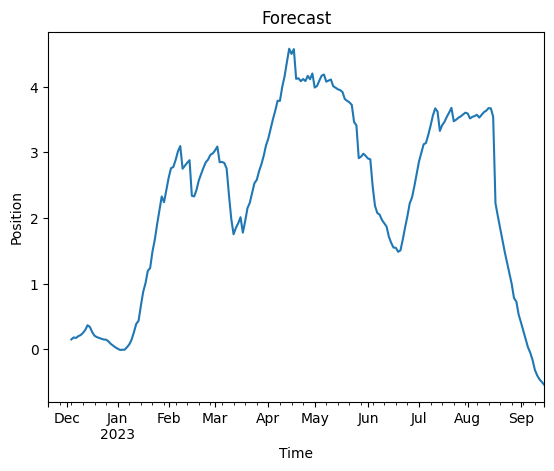

In [30]:
ewmac.plot();
plt.title('Forecast')
plt.ylabel('Position')
plt.xlabel('Time')


Did we make money?


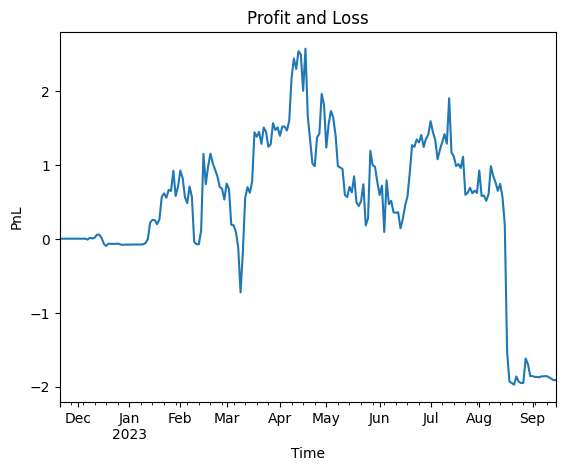

In [31]:
from systems.accounts.account_forecast import pandl_for_instrument_forecast
account = pandl_for_instrument_forecast(forecast=ewmac, price = price)
account.curve().plot();
plt.title('Profit and Loss')
plt.ylabel('PnL')
plt.xlabel('Time');

In [33]:
account.percent.stats()

[[('min', '-1.719'),
  ('max', '1.029'),
  ('median', '-0.0004545'),
  ('mean', '-0.008894'),
  ('std', '0.2762'),
  ('skew', '-0.7873'),
  ('ann_mean', '-2.277'),
  ('ann_std', '4.419'),
  ('sharpe', '-0.5152'),
  ('sortino', '-0.6089'),
  ('avg_drawdown', '-1.221'),
  ('time_in_drawdown', '0.8372'),
  ('calmar', '-0.5009'),
  ('avg_return_to_drawdown', '-1.865'),
  ('avg_loss', '-0.1667'),
  ('avg_gain', '0.1841'),
  ('gaintolossratio', '1.105'),
  ('profitfactor', '0.8976'),
  ('hitrate', '0.4483'),
  ('t_stat', '-0.4722'),
  ('p_value', '0.6373')],
 ('You can also plot / print:',
  ['rolling_ann_std', 'drawdown', 'curve', 'percent'])]